In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# method chaining in pandas

In [3]:
# method chain for dealing with loading dataset into a DataFrame
def read(fp):
    '''
        read dataset into DataFrame -- process dataset for use
    '''
    
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .drop('unnamed: 36', axis=1)
            .pipe(extract_city_names)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    
    return df

def extract_city_names(df):
    '''
        Chicago, IL to Chicago
    '''
    
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract('(.*), \w{2}', expand=False))
    df = df.copy()
    df[cols] = city
    
    return df

def time_to_datetime(df, cols):
    '''
        convert all columns with dates as strings to dates as datetimes
    '''
    
    df = df.copy()
    
    def converter(col):
        '''
            converts dates
        '''
        
        timepart = (col.astype(str)
                       .str.replace('\.0$', '') # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        
        return pd.to_datetime(df['fl_date'] + ' ' +
                                 timepart.str.slice(0, 2) + ':' +
                                 timepart.str.slice(2, 4),
                                 errors='coerce')
    
    df[cols] = df[cols].apply(converter)
    
    return df

In [4]:
df = read('856263442_T_ONTIME.csv')

In [5]:
output = 'flights.h5'
df.to_hdf(output, 'flights', format='table')

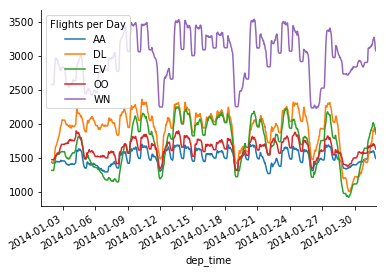

In [70]:
# EDA -- daily flight pattern
(df.dropna(subset=['dep_time', 'unique_carrier'])
   .loc[df['unique_carrier']
       .isin(df['unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   .groupby(['unique_carrier', pd.TimeGrouper('H')])
   .fl_num.count()
   .unstack(0)
   .fillna(0)
   .rolling(24)
   .sum()
   .rename_axis('Flights per Day', axis=1)
   .plot())

sns.despine()

In [57]:
# using decorators for logging
from functools import wraps
import logging

logging.basicConfig(filename='part2.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.debug('{}{}'.format(func.__name__, result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.debug('{}{}'.format(func.__name__, result.dtypes))
        return result
    return wrapper


@log_shape
@log_dtypes
def load(fp):
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    return df


In [58]:
df = load('856263442_T_ONTIME.csv')

In [74]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [75]:
%config InlineBackend.figure_format = 'png'

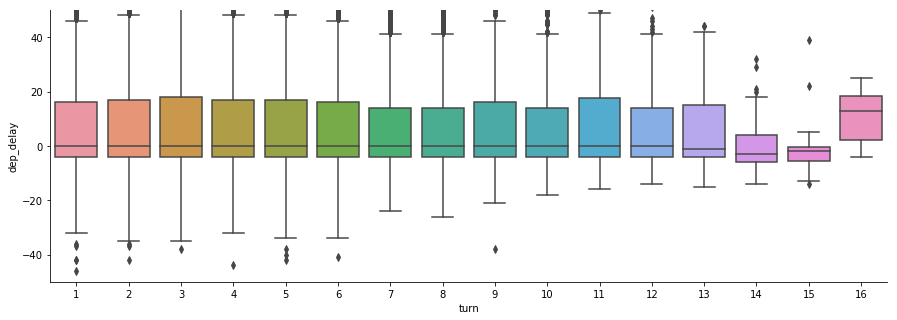

In [76]:
# does a plane with multiple flight on the same day get backed up, causing later flights to get delayed?
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
              .dropna()
              .sort_values('dep_time')
              .loc[lambda x: x.dep_delay < 500]
              .assign(turn=lambda x:
                     x.groupby(['fl_date', 'tail_num'])
                      .dep_time
                      .transform('rank').astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax)
ax.set_ylim(-50, 50)
sns.despine()

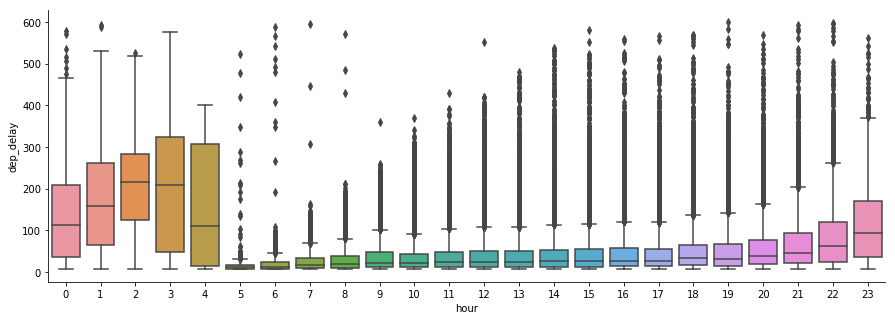

In [77]:
plt.figure(figsize=(15, 5))

(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay'))

sns.despine()